In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_curve, auc, precision_score, recall_score, f1_score)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. Loading the Dataset

In [2]:
df = pd.read_csv('data/filtered_thyroid_data.csv')


In [3]:
# Data Types and Info
print(df.info()) # data type information
print(df.describe()) # statistical summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              383 non-null    int64 
 1   Gender           382 non-null    object
 2   Hx Radiothreapy  382 non-null    object
 3   Adenopathy       383 non-null    object
 4   Pathology        380 non-null    object
 5   Focality         382 non-null    object
 6   Risk             382 non-null    object
 7   T                383 non-null    object
 8   N                382 non-null    object
 9   M                383 non-null    object
 10  Stage            383 non-null    object
 11  Response         382 non-null    object
 12  Recurred         383 non-null    object
dtypes: int64(1), object(12)
memory usage: 39.0+ KB
None
              Age
count  383.000000
mean    40.866841
std     15.134494
min     15.000000
25%     29.000000
50%     37.000000
75%     51.000000
max     82.000000


In [4]:
# Checking for Duplicates
print("="*60)
print("DUPLICATE ROWS CHECK")
print("="*60)
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")
else:
    print("✓ No duplicate rows found - Data is clean!")


DUPLICATE ROWS CHECK
Number of duplicate rows: 53
Removing duplicates...
Dataset shape after removing duplicates: (330, 13)


TARGET VARIABLE DISTRIBUTION
No     222
Yes    108
Name: Recurred, dtype: int64

Class Balance Ratio: {'No': 0.673, 'Yes': 0.327}


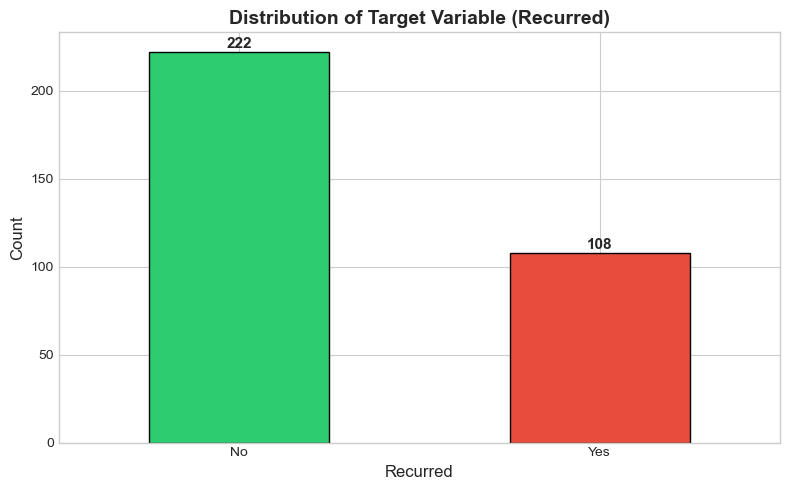

In [5]:
# Target Variable Distribution
print("="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)
print(df['Recurred'].value_counts())
print(f"\nClass Balance Ratio: {df['Recurred'].value_counts(normalize=True).round(3).to_dict()}")

# Visualize target distribution
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
df['Recurred'].value_counts().plot(kind='bar', color=colors, edgecolor='black', ax=ax)
ax.set_title('Distribution of Target Variable (Recurred)', fontsize=14, fontweight='bold')
ax.set_xlabel('Recurred', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['No', 'Yes'], rotation=0)
for i, v in enumerate(df['Recurred'].value_counts().values):
    ax.text(i, v + 2, str(v), ha='center', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()


In [6]:
# Categorical Features Overview
print("="*60)
print("CATEGORICAL FEATURES VALUE COUNTS")
print("="*60)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


CATEGORICAL FEATURES VALUE COUNTS

Gender:
F    259
M     70
Name: Gender, dtype: int64

Hx Radiothreapy:
No     322
Yes      7
Name: Hx Radiothreapy, dtype: int64

Adenopathy:
No           224
Right         48
Bilateral     32
Left          17
Extensive      7
Posterior      2
Name: Adenopathy, dtype: int64

Pathology:
Papillary         244
Micropapillary     36
Follicular         28
Hurthel cell       19
Name: Pathology, dtype: int64

Focality:
Uni-Focal      193
Multi-Focal    136
Name: Focality, dtype: int64

Risk:
Low             195
Intermediate    102
High             32
Name: Risk, dtype: int64

T:
T2     118
T3a     96
T1a     37
T1b     35
T4a     20
T3b     16
T4b      8
Name: T, dtype: int64

N:
N0     215
N1b     92
N1a     22
Name: N, dtype: int64

M:
M0    312
M1     18
Name: M, dtype: int64

Stage:
I      280
II      32
IVB     11
III      4
IVA      3
Name: Stage, dtype: int64

Response:
Excellent                 154
Structural Incomplete      91
Indeterminate         

## 2. Data Preprocessing

### Handling Missing Values

In [7]:
# Missing Values Analysis
print("="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
missing_values = df.isna().sum()
missing_percentage = (df.isna().sum() / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})
print(missing_df)
print(f"\nTotal Missing Values: {missing_values.sum()}")

if missing_values.sum() == 0:
    print("✓ No missing values - Data is clean!")
else:
    print(f"⚠ Found {missing_values.sum()} missing values that need handling.")

MISSING VALUES ANALYSIS
                 Missing Values  Percentage (%)
Age                           0            0.00
Gender                        1            0.30
Hx Radiothreapy               1            0.30
Adenopathy                    0            0.00
Pathology                     3            0.91
Focality                      1            0.30
Risk                          1            0.30
T                             0            0.00
N                             1            0.30
M                             0            0.00
Stage                         0            0.00
Response                      1            0.30
Recurred                      0            0.00

Total Missing Values: 9
⚠ Found 9 missing values that need handling.


In [8]:
# Filling categorical missing values with the mode
print("="*60)
print("HANDLING MISSING VALUES")
print("="*60)
for column in df.columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling '{column}' missing values with mode: '{mode_value}'")
        df[column] = df[column].fillna(mode_value)

# Verify all missing values are handled
print(f"\nMissing values after imputation: {df.isna().sum().sum()}")
print("✓ All missing values have been handled!")

HANDLING MISSING VALUES
Filling 'Gender' missing values with mode: 'F'
Filling 'Hx Radiothreapy' missing values with mode: 'No'
Filling 'Pathology' missing values with mode: 'Papillary'
Filling 'Focality' missing values with mode: 'Uni-Focal'
Filling 'Risk' missing values with mode: 'Low'
Filling 'N' missing values with mode: 'N0'
Filling 'Response' missing values with mode: 'Excellent'

Missing values after imputation: 0
✓ All missing values have been handled!


### Encoding the Target Variable ['Recurred']

In [9]:
# Assuming 'Yes' = 1 (Recurred) and 'No' = 0 (Not Recurred)
le_target = LabelEncoder()
df['Recurred'] = le_target.fit_transform(df['Recurred'])

In [10]:
# Separating Features (X) and Target (y)
X = df.drop('Recurred', axis=1)
y = df['Recurred']

### Encoding Categorical Features (One-Hot Encoding)


In [11]:
# This converts text categories into numerical binary columns (0s and 1s)
categorical_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [12]:
# Splitting the dataset into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [13]:
# KNN is distance-based; Scaling ensures all features contribute equally.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Model Implementation


## Decision Tree



In [14]:
# Train Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)
y_pred_dt = dt_classifier.predict(X_test_scaled)

print("✓ Decision Tree Classifier trained successfully!")
print(f"  Tree Depth: {dt_classifier.get_depth()}")
print(f"  Number of Leaves: {dt_classifier.get_n_leaves()}")


✓ Decision Tree Classifier trained successfully!
  Tree Depth: 8
  Number of Leaves: 21


## K-Nearest Neighbors (KNN) Classifier


In [15]:
# Train KNN Classifier (using k=5 as standard starting point)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)
y_pred_knn = knn_classifier.predict(X_test_scaled)

print("✓ KNN Classifier trained successfully!")
print(f"  Number of neighbors (K): 5")


c:\Users\Administrator\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Administrator\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Administrator\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Administrator\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Administrator\anaconda3\Lib\subprocess.py", line 1538, in _execute_child


✓ KNN Classifier trained successfully!
  Number of neighbors (K): 5


## 4. Model Evaluation


In [16]:
# Calculate Accuracy
dt_acc = accuracy_score(y_test, y_pred_dt)
knn_acc = accuracy_score(y_test, y_pred_knn)

print("="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

# Decision Tree Results
print(f"\n{'─'*60}")
print("DECISION TREE CLASSIFIER")
print(f"{'─'*60}")
print(f"Accuracy: {dt_acc:.4f} ({dt_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Not Recurred', 'Recurred']))

# KNN Results
print(f"\n{'─'*60}")
print("K-NEAREST NEIGHBORS CLASSIFIER")
print(f"{'─'*60}")
print(f"Accuracy: {knn_acc:.4f} ({knn_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['Not Recurred', 'Recurred']))

# Quick Comparison
print("="*60)
print("QUICK COMPARISON")
print("="*60)
if dt_acc > knn_acc:
    print(f"\n✓ Decision Tree performed better ({dt_acc:.4f} vs {knn_acc:.4f})")
elif knn_acc > dt_acc:
    print(f"\n✓ KNN performed better ({knn_acc:.4f} vs {dt_acc:.4f})")
else:
    print(f"\n✓ Both models performed equally well ({dt_acc:.4f})")


MODEL EVALUATION RESULTS

────────────────────────────────────────────────────────────
DECISION TREE CLASSIFIER
────────────────────────────────────────────────────────────
Accuracy: 0.9545 (95.45%)

Classification Report:
              precision    recall  f1-score   support

Not Recurred       0.95      0.97      0.96        40
    Recurred       0.96      0.92      0.94        26

    accuracy                           0.95        66
   macro avg       0.96      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66


────────────────────────────────────────────────────────────
K-NEAREST NEIGHBORS CLASSIFIER
────────────────────────────────────────────────────────────
Accuracy: 0.9242 (92.42%)

Classification Report:
              precision    recall  f1-score   support

Not Recurred       0.89      1.00      0.94        40
    Recurred       1.00      0.81      0.89        26

    accuracy                           0.92        66
   macro avg       0.94     

## 5. Visualization & Detailed Analysis


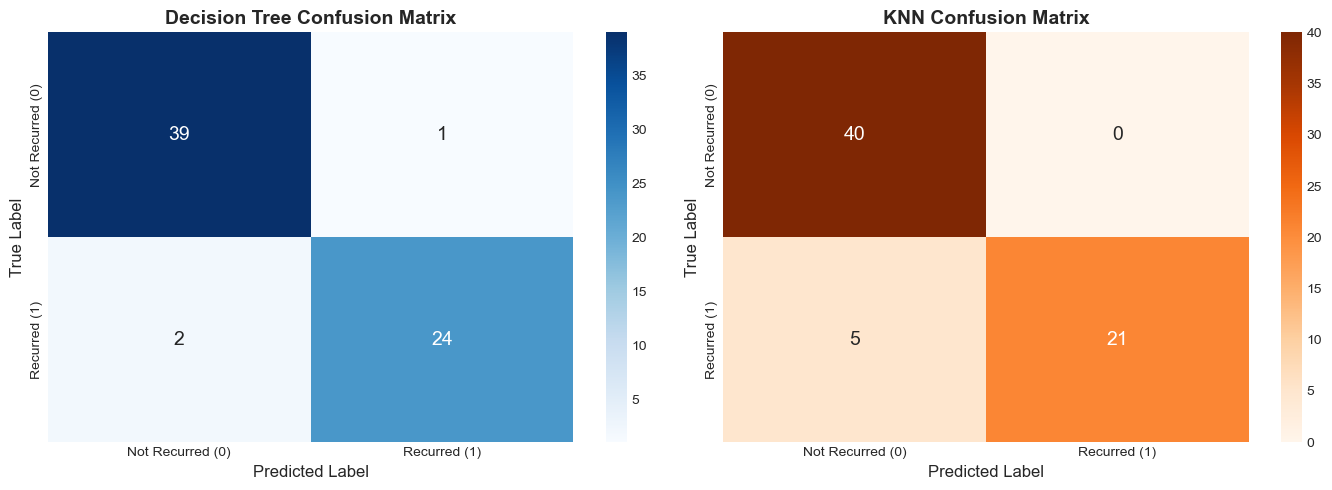


CONFUSION MATRIX INTERPRETATION

Decision Tree:
  • True Negatives (Correctly predicted Not Recurred): 39
  • False Positives (Incorrectly predicted Recurred): 1
  • False Negatives (Incorrectly predicted Not Recurred): 2
  • True Positives (Correctly predicted Recurred): 24

KNN:
  • True Negatives (Correctly predicted Not Recurred): 40
  • False Positives (Incorrectly predicted Recurred): 0
  • False Negatives (Incorrectly predicted Not Recurred): 5
  • True Positives (Correctly predicted Recurred): 21


In [17]:
# 5.1 Confusion Matrices for Both Models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Recurred (0)', 'Recurred (1)'],
            yticklabels=['Not Recurred (0)', 'Recurred (1)'],
            annot_kws={'size': 14})
axes[0].set_title('Decision Tree Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# KNN Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Not Recurred (0)', 'Recurred (1)'],
            yticklabels=['Not Recurred (0)', 'Recurred (1)'],
            annot_kws={'size': 14})
axes[1].set_title('KNN Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n" + "="*60)
print("CONFUSION MATRIX INTERPRETATION")
print("="*60)
print(f"\nDecision Tree:")
print(f"  • True Negatives (Correctly predicted Not Recurred): {cm_dt[0,0]}")
print(f"  • False Positives (Incorrectly predicted Recurred): {cm_dt[0,1]}")
print(f"  • False Negatives (Incorrectly predicted Not Recurred): {cm_dt[1,0]}")
print(f"  • True Positives (Correctly predicted Recurred): {cm_dt[1,1]}")

print(f"\nKNN:")
print(f"  • True Negatives (Correctly predicted Not Recurred): {cm_knn[0,0]}")
print(f"  • False Positives (Incorrectly predicted Recurred): {cm_knn[0,1]}")
print(f"  • False Negatives (Incorrectly predicted Not Recurred): {cm_knn[1,0]}")
print(f"  • True Positives (Correctly predicted Recurred): {cm_knn[1,1]}")


# 5.2 Decision Tree Structure Visualization (limited depth for clarity)

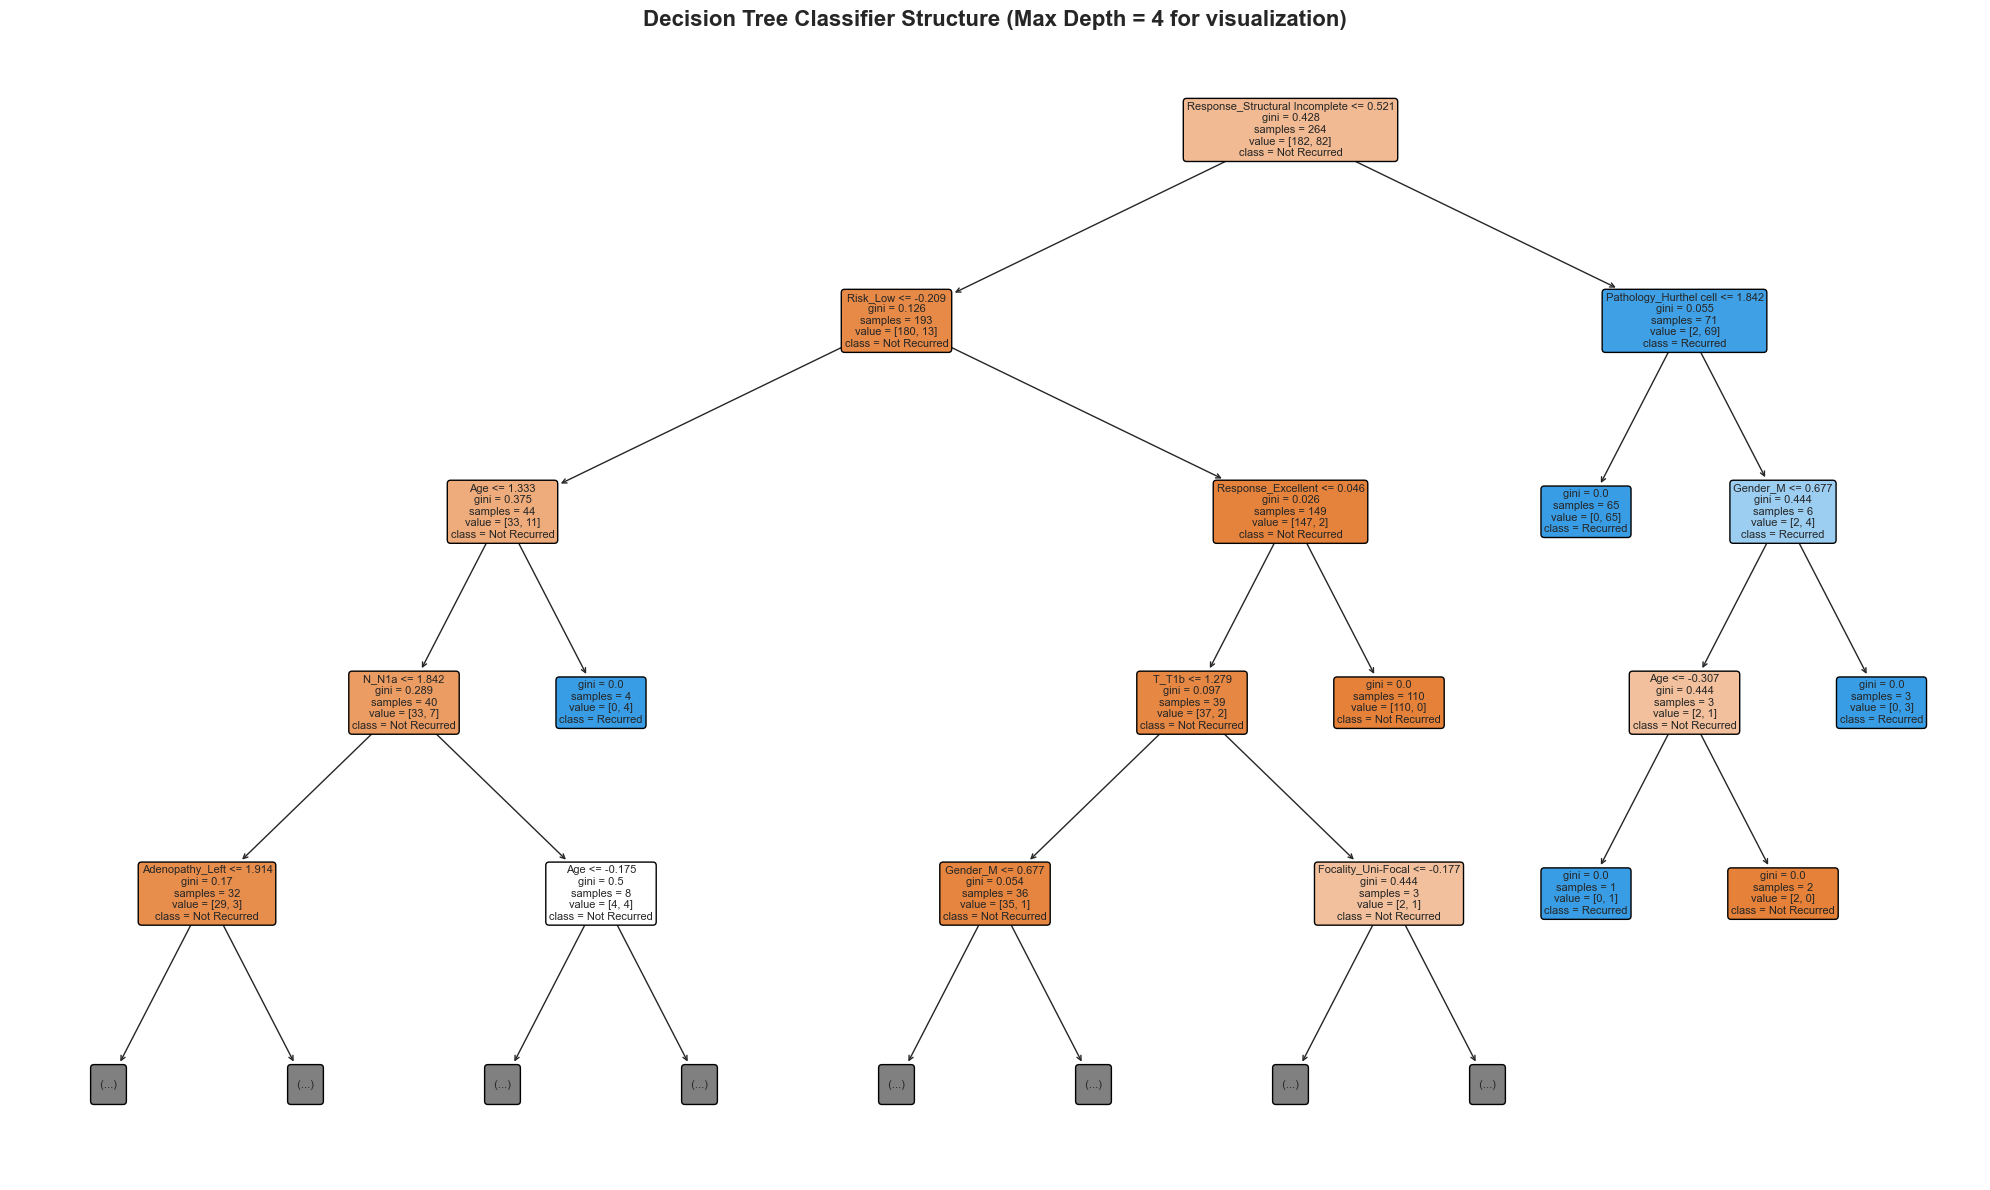

In [18]:
plt.figure(figsize=(20, 12))
plot_tree(dt_classifier, 
          feature_names=X.columns.tolist(),
          class_names=['Not Recurred', 'Recurred'],
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=4)  # Limiting depth for readability
plt.title('Decision Tree Classifier Structure (Max Depth = 4 for visualization)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# 5.3 Feature Importance from Decision Tree


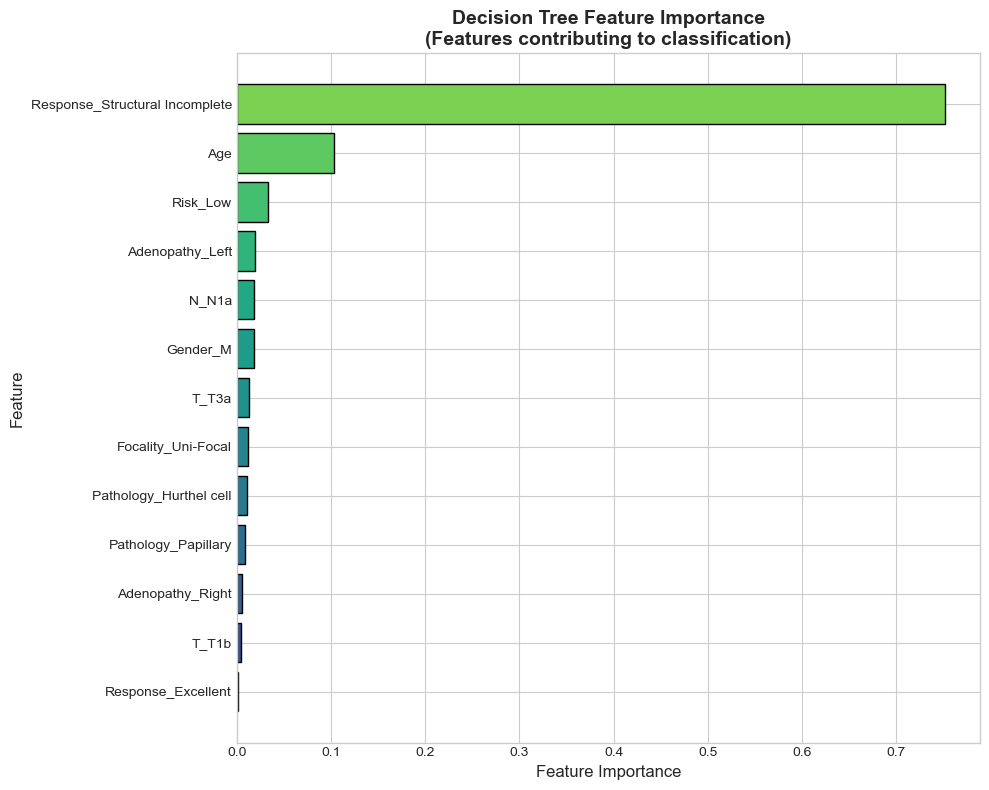

TOP 10 MOST IMPORTANT FEATURES
  Response_Structural Incomplete: 0.7511
  Age: 0.1027
  Risk_Low: 0.0336
  Adenopathy_Left: 0.0192
  N_N1a: 0.0187
  Gender_M: 0.0181
  T_T3a: 0.0133
  Focality_Uni-Focal: 0.0118
  Pathology_Hurthel cell: 0.0108
  Pathology_Papillary: 0.0088


In [19]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=True)

# Filter out zero-importance features for cleaner visualization
feature_importance_nonzero = feature_importance[feature_importance['Importance'] > 0]

plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance_nonzero)))
plt.barh(feature_importance_nonzero['Feature'], 
         feature_importance_nonzero['Importance'], 
         color=colors, edgecolor='black')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Decision Tree Feature Importance\n(Features contributing to classification)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display top 10 most important features
print("="*60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*60)
top_features = feature_importance.tail(10).sort_values('Importance', ascending=False)
for idx, row in top_features.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")


# 5.4 Finding the Optimal K for KNN (Elbow Method)

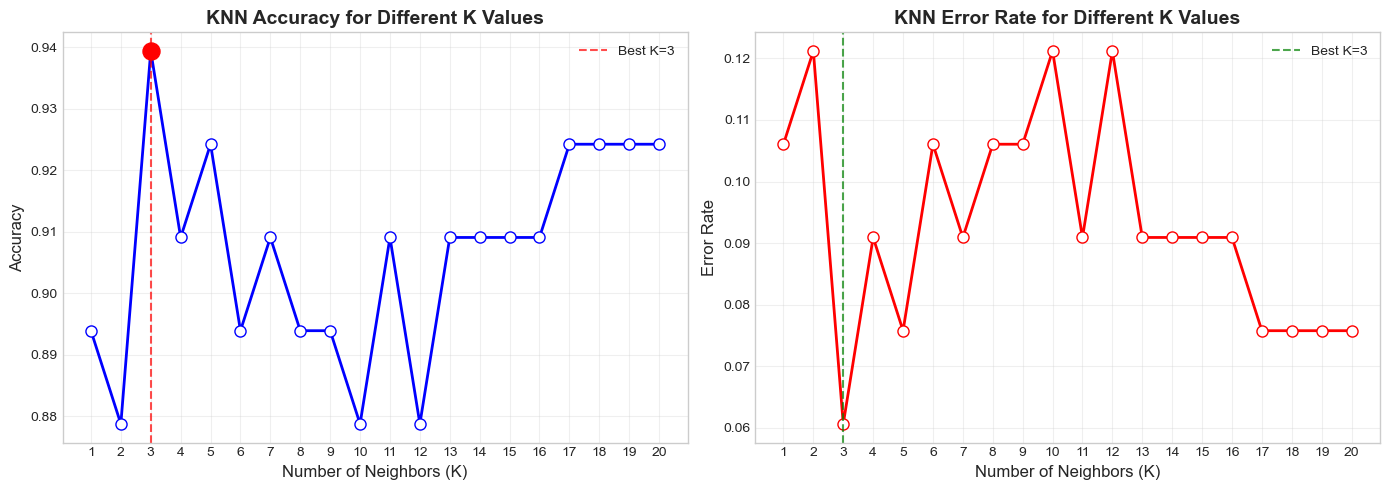


OPTIMAL K VALUE ANALYSIS
Best K value: 3
Best Accuracy at K=3: 0.9394


In [20]:
k_range = range(1, 21)
accuracies = []
error_rates = []

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred_temp))
    error_rates.append(1 - accuracy_score(y_test, y_pred_temp))

# Plot accuracy vs K
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
axes[0].plot(k_range, accuracies, 'b-o', linewidth=2, markersize=8, markerfacecolor='white')
axes[0].set_xlabel('Number of Neighbors (K)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('KNN Accuracy for Different K Values', fontsize=14, fontweight='bold')
axes[0].set_xticks(k_range)
axes[0].grid(True, alpha=0.3)

# Highlight best K
best_k = k_range[np.argmax(accuracies)]
best_acc = max(accuracies)
axes[0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
axes[0].scatter([best_k], [best_acc], color='red', s=150, zorder=5)
axes[0].legend()

# Error Rate Plot
axes[1].plot(k_range, error_rates, 'r-o', linewidth=2, markersize=8, markerfacecolor='white')
axes[1].set_xlabel('Number of Neighbors (K)', fontsize=12)
axes[1].set_ylabel('Error Rate', fontsize=12)
axes[1].set_title('KNN Error Rate for Different K Values', fontsize=14, fontweight='bold')
axes[1].set_xticks(k_range)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=best_k, color='green', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"OPTIMAL K VALUE ANALYSIS")
print(f"{'='*60}")
print(f"Best K value: {best_k}")
print(f"Best Accuracy at K={best_k}: {best_acc:.4f}")


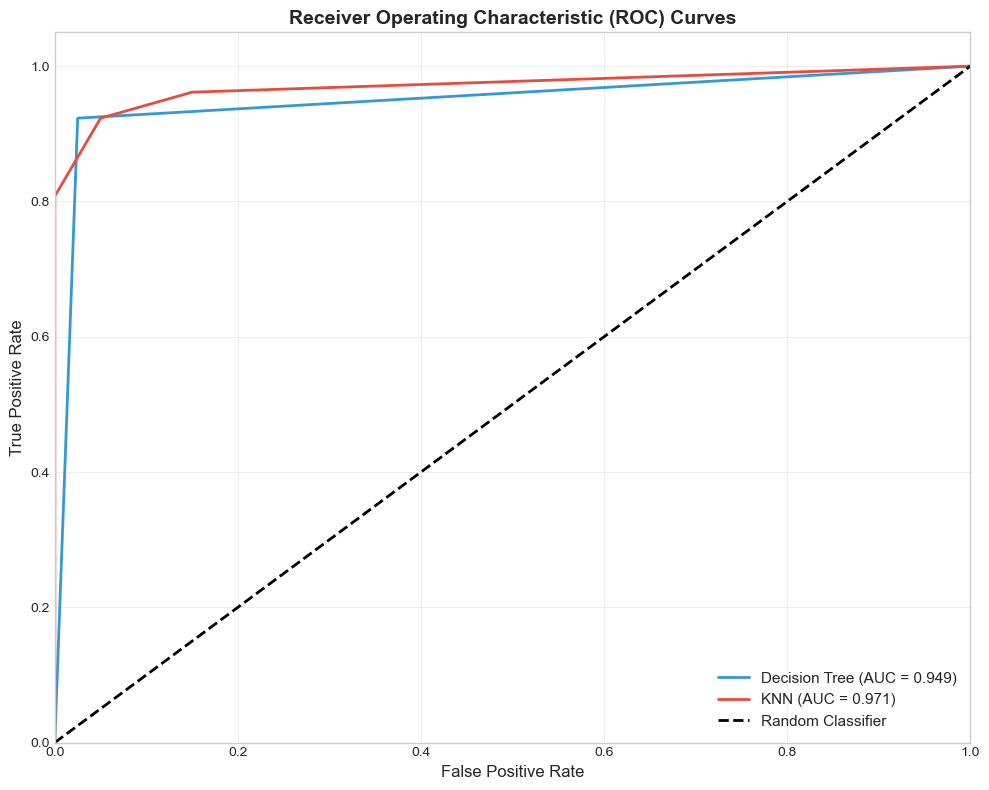


ROC-AUC SCORES
Decision Tree AUC: 0.9490
KNN AUC: 0.9712

Note: Higher AUC indicates better model performance.


In [21]:
# 5.5 ROC Curves for Both Models
plt.figure(figsize=(10, 8))

# Decision Tree ROC
y_prob_dt = dt_classifier.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# KNN ROC
y_prob_knn = knn_classifier.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curves
plt.plot(fpr_dt, tpr_dt, color='#3498db', lw=2, 
         label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot(fpr_knn, tpr_knn, color='#e74c3c', lw=2, 
         label=f'KNN (AUC = {roc_auc_knn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"ROC-AUC SCORES")
print(f"{'='*60}")
print(f"Decision Tree AUC: {roc_auc_dt:.4f}")
print(f"KNN AUC: {roc_auc_knn:.4f}")
print(f"\nNote: Higher AUC indicates better model performance.")


### 5.6 Final Model Comparison


MODEL PERFORMANCE METRICS COMPARISON
               Accuracy  Precision  Recall  F1-Score     AUC
Decision Tree    0.9545       0.96  0.9231    0.9412  0.9490
KNN              0.9242       1.00  0.8077    0.8936  0.9712


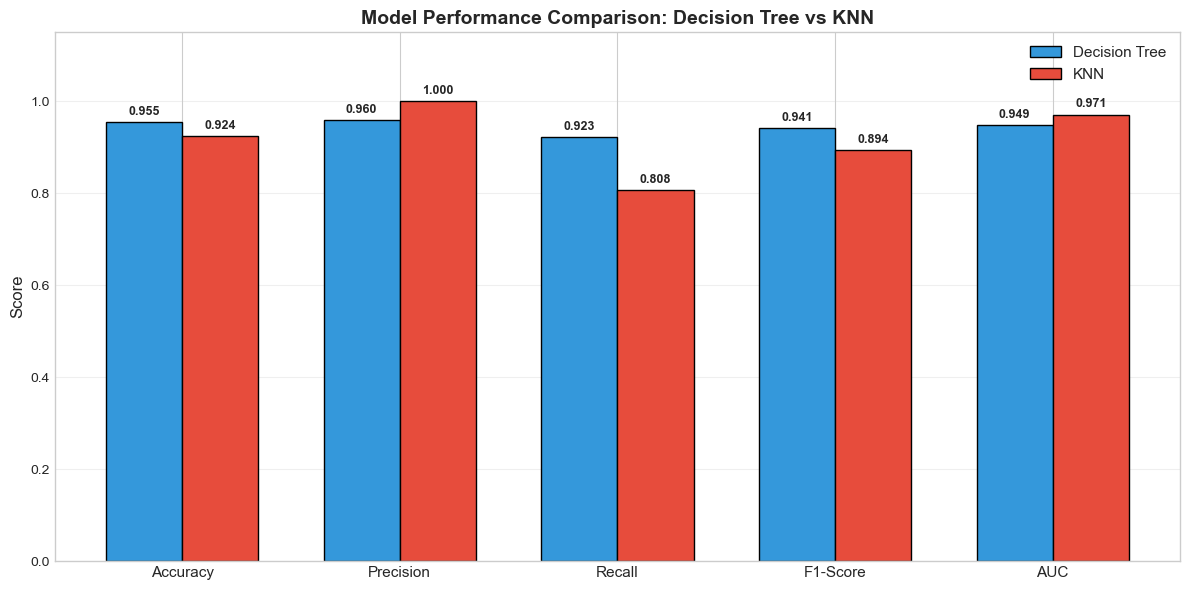


FINAL SUMMARY

🏆 Best Performing Model: Decision Tree

Key Insights:
  • Decision Tree achieved 95.45% accuracy
  • KNN achieved 92.42% accuracy
  • Decision Tree AUC: 0.9490
  • KNN AUC: 0.9712


In [ ]:
# 5.6 Model Performance Comparison Chart

# Calculate metrics for both models
metrics = {
    'Accuracy': [dt_acc, knn_acc],
    'Precision': [precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_knn)],
    'Recall': [recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_knn)],
    'F1-Score': [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_knn)],
    'AUC': [roc_auc_dt, roc_auc_knn]
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(metrics, index=['Decision Tree', 'KNN'])
print("="*60)
print("MODEL PERFORMANCE METRICS COMPARISON")
print("="*60)
print(comparison_df.round(4))

# Visualization
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, comparison_df.loc['Decision Tree'], width, 
               label='Decision Tree', color='#3498db', edgecolor='black')
bars2 = ax.bar(x + width/2, comparison_df.loc['KNN'], width, 
               label='KNN', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison: Decision Tree vs KNN', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics.keys(), fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.15)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
winner = "Decision Tree" if dt_acc > knn_acc else "KNN" if knn_acc > dt_acc else "Both models tied"
print(f"\n Best Performing Model: {winner}")
print(f"\nKey Insights:")
print(f"  • Decision Tree achieved {dt_acc*100:.2f}% accuracy")
print(f"  • KNN achieved {knn_acc*100:.2f}% accuracy")
print(f"  • Decision Tree AUC: {roc_auc_dt:.4f}")
print(f"  • KNN AUC: {roc_auc_knn:.4f}")
